# Green peas: obtaining the data

In this notebook, we show how to use `astroquery` to download archival data that will become relevant to our project. I strongly recommend that you [read the documentation](http://astroquery.readthedocs.io/en/latest/) in order to understand how this works. Here I will provide a sample query of the Sloan Digital Sky Survey (SDSS) servers using SQL (Structured Query Language), but you can design your own queries directly using `astroquery` functions.

We are also interested in the science objective of identifying *green pea galaxies* (GPs). Before getting too deep into this project, it might be a good idea to skim the paper by [Cardamone et al. (2009, MNRAS)](http://adsabs.harvard.edu/abs/2009MNRAS.399.1191C).

In [1]:
from astroquery.sdss import SDSS

/home/john/anaconda2/envs/astrohack/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [38]:
query_string = \
"""SELECT TOP 100000
    ra, dec,
    u, g, r, i, z,
    petrorad_r,
    run, 
    rerun, 
    camcol, 
    field, 
    objID 
FROM Galaxy
"""

table = SDSS.query_sql(query_string)

Use selection criteria defined in Section 2.1 of the GP paper.

In [42]:
gps = table[(table['r'] >= 18.0) &
            (table['r'] <= 20.5) &
            (table['petrorad_r'] <= 2.0) &
            (table['u'] - table['r'] <= 2.5) &
            (table['r'] - table['i'] <= -0.2) &
            (table['r'] - table['z'] <= 0.5) &
            (table['g'] - 2*table['r'] + table['i'] >= 0.5) &
            (table['u'] - table['r'] >= 2.5 * (table['r'] - table['z'])) 
           ]

# sort by g magnitude
gps.sort('g')
gps

ra,dec,u,g,r,i,z,petrorad_r,run,rerun,camcol,field,objID
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
60.9741378022297,-0.697952790353425,19.59234,18.30291,20.42401,31.40054,27.37063,0.2641083,109,301,2,176,1237645941833466540
64.2245086906574,0.143350905933666,20.07485,19.6754,18.87128,19.18843,25.778,1.809029,109,301,4,197,1237645942908584735
57.8669886925487,0.898801336904768,22.60129,19.90328,20.43946,25.89697,20.99956,1.867364,109,301,6,155,1237645943979573677
61.0232768685206,0.626266349014782,20.34905,20.02538,19.04926,19.87565,24.59248,1.279476,109,301,5,176,1237645943444079184
62.2565455353683,-1.1623100018234,20.64199,20.25792,19.92573,20.25467,20.22071,1.431424,109,301,1,184,1237645941297119468
58.8703268420156,0.203481340657835,21.64922,20.55967,19.55046,20.35474,19.77206,1.398905,109,301,4,162,1237645942906290704
64.5901715625301,-0.280732917032327,20.75836,21.06598,20.33464,21.40011,20.78422,1.326889,109,301,3,200,1237645942371910502
60.5172529660557,0.11889056522575,21.18915,21.07145,19.68425,20.94428,20.20548,1.156188,109,301,4,173,1237645942907011638
66.5985055470242,0.478909661566112,20.40761,21.19101,19.2825,27.32253,19.66029,1.331244,109,301,5,213,1237645943446504552


Let us take a look at some of these data.

In [4]:
from astropy.coordinates import SkyCoord

# examine first one 
u_images = []
g_images = []
r_images = []
for images, bands in zip([u_images, g_images, r_images], ['u', 'g', 'r']):
    for ra, dec in gps[['ra', 'dec']][0:1]:
        images += SDSS.get_images(coordinates=SkyCoord(ra, dec, unit='deg'), band=bands)

Note: below code doesn't play well with `plt.imshow()`.

In [15]:
import numpy as np
from skimage import img_as_float

# concatenate images from each band
color_image = np.zeros((*images[0][0].data.shape, 3))

for k, band_images in enumerate([u_images, g_images, r_images]):
    im = np.nanmean([(hdulist[0].data - np.nanmin(hdulist[0].data)) 
                     / np.nanmax(hdulist[0].data) for hdulist in band_images], axis=0)
    color_image[:, :, k] = img_as_float(im)

Okay let's sort the previous table by increasing g-magnitude (brightest-first).

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.589e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.044e-01 [aplpy.core]


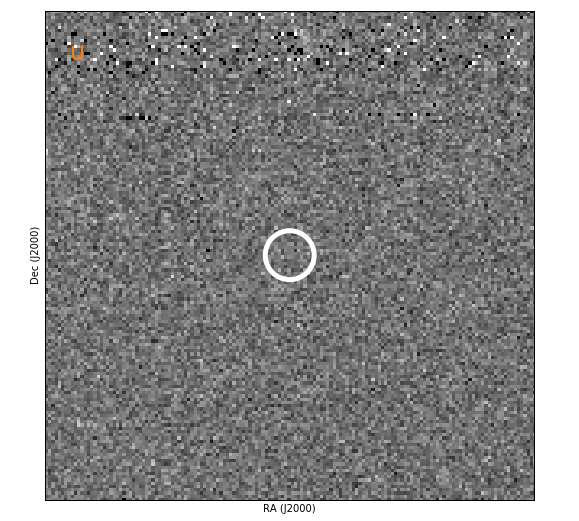

INFO: Auto-setting vmin to -7.058e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.657e-01 [aplpy.core]


/home/john/anaconda2/envs/astrohack/lib/python3.6/site-packages/aplpy/wcs_util.py:515: UserWarning: Pixels are not square, using an average pixel scale
  warnings.warn("Pixels are not square, using an average pixel scale")


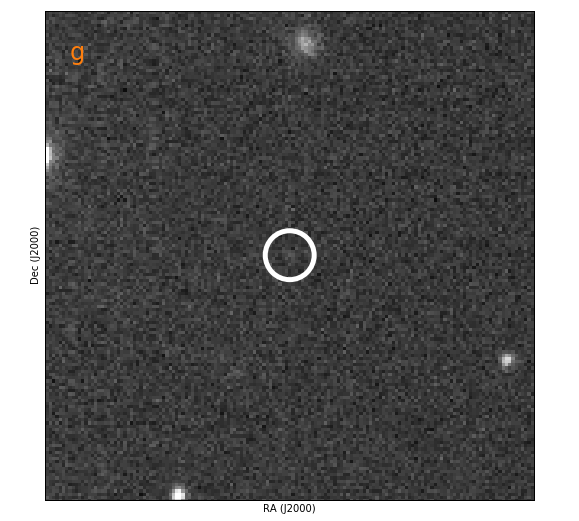

INFO: Auto-setting vmin to -1.189e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.803e-01 [aplpy.core]


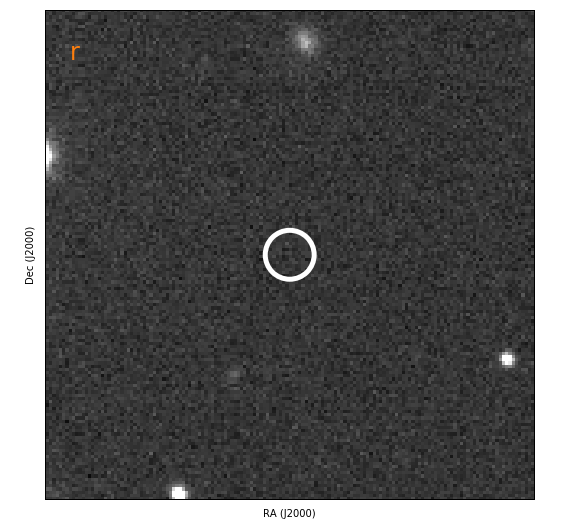

In [45]:
import aplpy
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# select image labeled n
n = 0

ra, dec = gps[['ra', 'dec']][n]

u_images = []
g_images = []
r_images = []
for images, bands in zip([u_images, g_images, r_images], ['u', 'g', 'r']):
    ra, dec = gps[['ra', 'dec']].as_array()[n]
    images += SDSS.get_images(coordinates=SkyCoord(ra, dec, unit='deg'), band=bands)
        

for band, band_images in zip(['u', 'g', 'r'], [u_images, g_images, r_images]):
    # get first hdulist in set of images
    hdulist = band_images[0]
    
    im = hdulist['PRIMARY'].data
    header = hdulist['PRIMARY'].header
    
    fig = aplpy.FITSFigure(hdulist)
    fig.show_grayscale()
    
    # recenter image  
    fig.recenter(ra, dec, radius=30./3600)
    
    # draw 3 arcsec circle around GP candidate
    fig.show_circles(ra, dec, linewidth=5., radius=3./3600, edgecolor='white') 
    
    ax = plt.gca()
    ax.text(0.05, 0.9, band, color='C1', fontsize=24, transform=ax.transAxes)
    
    plt.show()